# Programming Assignment: CleanVision AI - Optimizing Models for Metro City's Smart Fleet

## Your Mission: Smart City Cleanup Initiative 🏙️

**Welcome to CleanVision AI!**

Congratulations on joining CleanVision AI as a Machine Learning Engineer! Our startup has just landed a major contract with the Metro City Council to revolutionize urban waste management. Here's the situation:

**The Challenge:**  
Metro City wants to deploy AI-powered cameras on their existing fleet of 500 street cleaning vehicles to automatically identify areas that need attention. The city has provided us with a pre-trained ResNet-18 model that accurately classifies street scenes into three categories: *clean*, *litter*, and *recycle*. It works perfectly in the cloud—but there's a catch.

**The Problem:**  
The street cleaning vehicles are equipped with **edge devices** (similar to Raspberry Pi) with:
- ❌ No GPU
- ❌ Limited RAM (4GB)
- ❌ Constrained storage (16GB)
- ❌ CPU-only inference capabilities

The city's budget won't allow for hardware upgrades, and they need real-time inference (< 50ms per image) to make instant routing decisions. Our current model is **512 MB** and takes over **900ms per batch** on CPU—completely unusable for their needs.

**Your Task:**  
The city is expecting a demo in two weeks. Your manager has assigned you to optimize the model for deployment on these edge devices. The model must:
1. ✅ Run efficiently on CPU-only hardware
2. ✅ Fit within the storage constraints (target: < 150 MB)
3. ✅ Maintain accuracy above 95% (city requirement)
4. ✅ Achieve inference time under 50ms per image on CPU

**The Toolkit:**  
Your team lead suggests a three-stage optimization pipeline:
- **Stage 1: Pruning** - Remove redundant weights to reduce model size
- **Stage 2: Dynamic Quantization** - Convert heavy layers to INT8 for faster CPU inference  
- **Stage 3: Quantization-Aware Training (QAT)** - Fine-tune with quantization simulation for maximum accuracy retention

**Success Criteria:**  
If you succeed, Metro City will expand the contract to 50 other cities nationwide, making CleanVision AI a leader in urban tech solutions. The CFO is counting on you—let's make this model deployment-ready!

---

## Introduction

You have already trained many models; now it is time to shape one for life outside a notebook. This lab guides you through taking a pre-trained ResNet-18 based StreetClassifier and turning it into a version that is easier to store, faster on CPU, and ready for deployment on edge targets. Along the way you will practice saving and reloading model state, pruning parameters, applying quantization, and evaluating the trade offs among accuracy, latency, and size.

In this lab you will:

- Load the CleanStreetDataset, initialize a pre-trained StreetClassifier, and establish a baseline evaluation.

- Work with checkpoints by saving and restoring state_dict objects for both training and inference.

- Implement magnitude-based pruning across convolutional and linear layers, with options for unstructured and structured strategies, and verify sparsity and accuracy.

- Apply dynamic quantization to linear layers for a fast CPU speedup and benchmark the effect.

- Fuse common layer patterns and prepare a quantization-aware variant, fine-tune briefly, then convert to an INT8 model.

- Compare accuracy, inference time, and file size before and after compression to understand the impact of each step.

By the end, you will have a compact classifier that keeps performance close to the original while being far more efficient to run and ship—ready for deployment on Metro City's fleet!


# Table of Contents
- [ 1 - Setup and Imports](#1)
- [ 2 - Baseline Model and Dataset](#2)
  - [ 2.1 Dataset](#2-1)
  - [ 2.2 Model Definition](#2-2)
  - [ 2.3 Loading Pretrained Weights](#2-3)
- [ 3 - Model Pruning](#3)
  - [ Exercise 1](#ex01)
- [ 4 - Dynamic Quantization](#4)
  - [ 4.1 Benefits of Quantization](#4-1)
  - [ 4.2 Three Approaches to Quantization](#4-2)
  - [ 4.3 Dynamic Quantization (This Section)](#4-3)
    - [ Exercise 2](#ex02)
- [ 5 - Quantization-Aware Training (QAT)](#5)
  - [ 5.1 What is QAT and why use it?](#5-1)
    - [ Exercise 3](#ex03)
  - [ 5.2 Auxiliary Functions for QAT](#5-2)
    - [ Exercise 4](#ex04)


---
<a name='submission'></a>

<h4 style="color:green; font-weight:bold;">TIPS FOR SUCCESSFUL GRADING OF YOUR ASSIGNMENT:</h4>

* All cells are frozen except for the ones where you need to submit your solutions or when explicitly mentioned you can interact with it.

* In each exercise cell, look for comments `### START CODE HERE ###` and `### END CODE HERE ###`. These show you where to write the solution code. **Do not add or change any code that is outside these comments**.

* You can add new cells to experiment but these will be omitted by the grader, so don't rely on newly created cells to host your solution code, use the provided places for this.

* Avoid using global variables unless you absolutely have to. The grader tests your code in an isolated environment without running all cells from the top. As a result, global variables may be unavailable when scoring your submission. Global variables that are meant to be used will be defined in UPPERCASE.

* To submit your notebook for grading, first save it by clicking the 💾 icon on the top left of the page and then click on the `Submit assignment` button on the top right of the page.
---

<a id='1'></a>
## 1 - Setup and Imports


In [21]:
import copy
import torch
from torch.nn.utils import prune
import torch.nn as nn
import torch.ao.quantization as aoq

In [22]:
import os

from torchvision import transforms, datasets
from torch.utils.data import DataLoader

import helper_utils
import unittests

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {device}")

Using device: cuda


<a id='2'></a>
## 2 - Baseline Model and Dataset

**StreetClassifier** is a deep learning model designed to classify urban scene images into three categories:  
- **clean**  
- **litter**  
- **recycle** 

<a id='2-1'></a>
### 2.1 Dataset

For this task, we will use the **CleanStreetDataset**, which is already divided into **training**, **development**, and **test** splits.  
In the code below, you'll see how the datasets are loaded and how data preprocessing and augmentation transforms are applied to prepare the data for training and evaluation.

In [24]:
dataset_path = "./data/"

# Define transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

eval_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets
train_dataset = datasets.ImageFolder(root=os.path.join(dataset_path, 'train'), transform=train_transform)
dev_dataset = datasets.ImageFolder(root=os.path.join(dataset_path, 'dev'), transform=eval_transform)
test_dataset = datasets.ImageFolder(root=os.path.join(dataset_path, 'test'), transform=eval_transform)

# Create dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

print("Number of training samples:", len(train_dataset))
print("Number of validation samples:", len(dev_dataset))
print("Number of test samples:", len(test_dataset))
print("\nClass mapping:", train_dataset.class_to_idx)

Number of training samples: 3782
Number of validation samples: 100
Number of test samples: 117

Class mapping: {'clean': 0, 'litter': 1, 'recycle': 2}


You can visualize some examples with the following helper function.

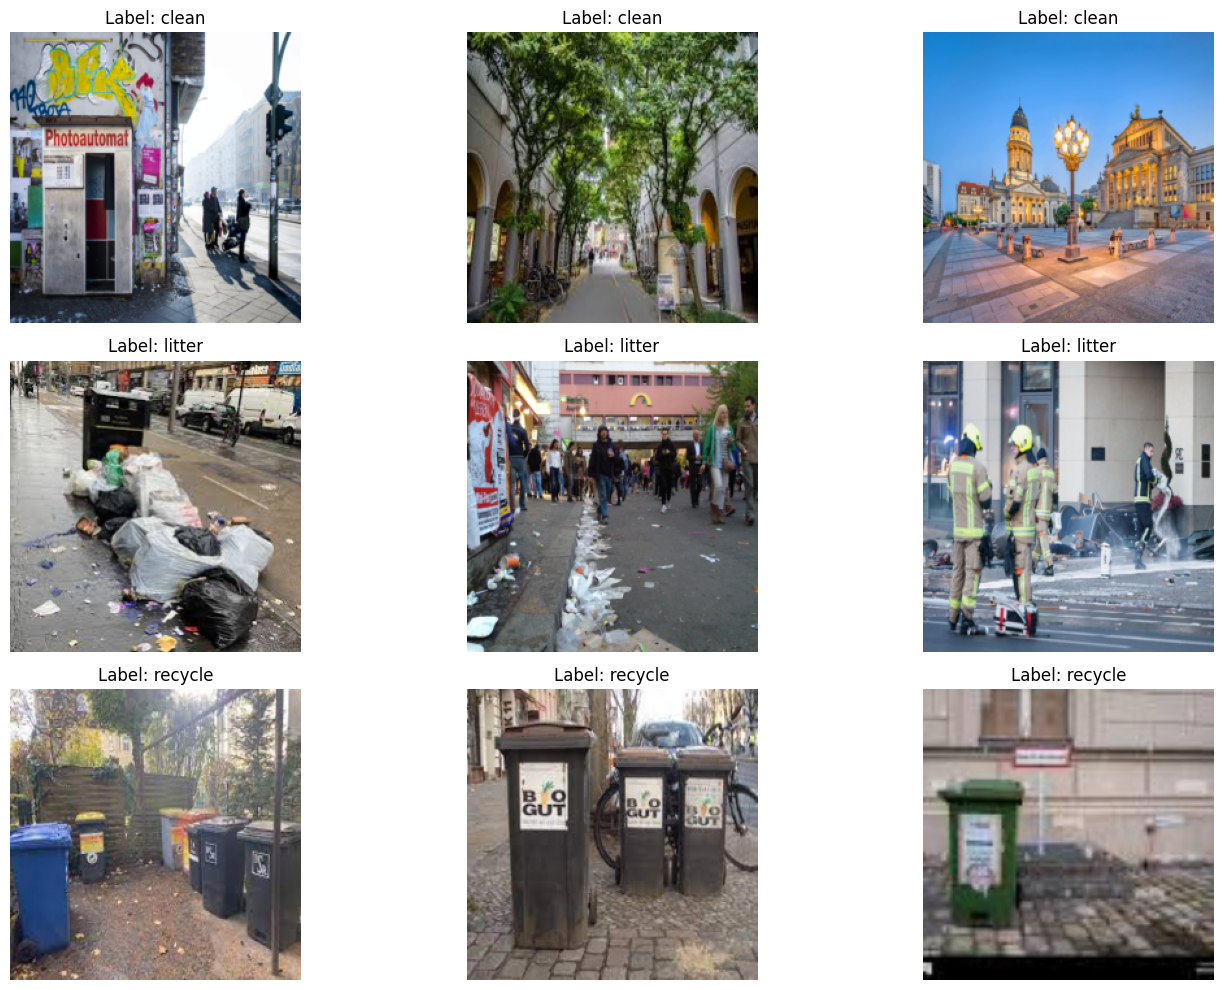

In [25]:
helper_utils.display_some_images(test_dataset)

<a id='2-2'></a>
### 2.2 Model Definition

The **StreetClassifier** model builds on **ResNet-18**, a well-known convolutional neural network pretrained on ImageNet.  
In this implementation the final classifier layer was replaced so the model can predict the three target classes of our dataset (*clean*, *litter*, and *recycle*). 

To make your work easier the ResNet-18 has been modified so it can use QAT in latter exercises.
You can see its architecture and details with the following code:

In [26]:
# Use the base model
model = helper_utils.resnet18_qat_ready_pretrained(num_classes=3, use_quant_stubs=False).to(device)
print(model)

QATResNet18(
  (quant): Identity()
  (stem): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): QATBasicBlock(
      (block): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (downsample): Identity()
      (skip_add): FloatFunctional(
        (activation_post_process): Identity()
      )
      (out_relu): ReLU(inplace=True)
    )
  

<a id='2-3'></a>
### 2.3 Loading Pretrained Weights

For the exercises, we will work with a **pretrained StreetClassifier model**. The model weights are stored in the file **`street_classifier_weights.pt`**.  

We will load the weights and then use the `compute_accuracy` function to evaluate the model's performance on the test set.

In [27]:

# Load the final model checkpoint
model_weights = torch.load("street_classifier_weights.pt", map_location="cpu")
model.load_state_dict(model_weights)

# Compute accuracy of the loaded model
base_accuracy = helper_utils.compute_accuracy(model, test_loader, device)
print(f"Model accuracy: {base_accuracy:.4f}")

Computing Accuracy:   0%|          | 0/4 [00:00<?, ?it/s]

Model accuracy: 0.9915


<a id='3'></a>
## 3 - Model Pruning

In this section, we will explore **model pruning**, a technique to reduce the size and complexity of neural networks by removing less important weights.  
To simplify the process, we provide a couple of helper functions:  

- `_iter_prunable_modules(model)` – iterates over all `Conv2d` and `Linear` layers, which are the layers we will target for pruning.  
- `finalize_pruning(model)` – makes pruning permanent by removing reparametrization and storing the pruned weights directly.  

These utilities will make it easier to apply and finalize pruning across the model.

In [28]:
def _iter_prunable_modules(model):
    """
    Iterate over modules that are eligible for pruning.

    Yields
    ------
    Tuple[str, nn.Module]
        Pairs of (fully-qualified module name, module) for layers that are
        prunable in this assignment: `nn.Conv2d` and `nn.Linear`.

    Notes
    -----
    - The qualified name comes from `model.named_modules()` and reflects the
      path within the module hierarchy (e.g., "block.0", "classifier.fc").
    - Use this generator to systematically apply pruning across the model.
    """
    for name, m in model.named_modules():
        if isinstance(m, (nn.Conv2d, nn.Linear)):
            yield name, m

def finalize_pruning(model):
    """
    Make pruning permanent by removing reparametrization wrappers.

    This converts any pruned parameter from the (`weight_orig`, `weight_mask`)
    reparametrization back to a regular `weight` `nn.Parameter` where the
    zeros are **materialized** in the stored tensor.
    """
    for _, module in _iter_prunable_modules(model):
        # Only remove if the parameter has been pruned
        if hasattr(module, "weight_orig") and hasattr(module, "weight_mask"):
            prune.remove(module, "weight")
    return model

<a id='ex01'></a>
### Exercise 1

Now you will implement the function `prune_model`, which applies pruning to all `Conv2d` and `Linear` layers in the **StreetClassifier** model.  
You can choose between two pruning modes:  

- **`l1_unstructured`** – removes a fraction of the smallest-magnitude weights.  
- **`ln_structured`** – removes entire output channels (structured pruning), which can lead to faster inference on some hardware.  

#### Why Prune a Model?
- **Smaller models** → reduced memory footprint and easier deployment on resource-constrained devices.  
- **Faster inference** → especially with structured pruning, which eliminates entire channels.  
- **Regularization effect** → pruning can sometimes improve generalization by removing redundant connections.  

#### Details: `prune_model`

Implement ```prune_model(model, amount=0.3, mode="l1_unstructured")```, a function that:

Applies magnitude-based pruning to the weights of every nn.Conv2d and nn.Linear layer in a given model using PyTorch's pruning reparametrization API. The pruning is applied in-place (adds weight_orig and weight_mask) and does not change any tensor shapes. To permanently bake zeros into the stored weights (remove reparametrization), a separate helper finalize_pruning(model) is provided for you to call afterward.

The function proceeds through these stages:

**Validate Inputs**

1. Ensure amount is a float in [0, 1].

2. Ensure mode is one of {"l1_unstructured", "ln_structured"}.

**Find Prunable Modules**
- Iterate over the model and select only ```nn.Conv2d``` and ```nn.Linear``` layers (a helper _iter_prunable_modules(model) is available).
- Skip any module that does not have a weight attribute.

**Apply Pruning (In-Place Reparametrization)**
- For unstructured pruning (default): Use ```prune.l1_unstructured(module, name="weight", amount=amount)``` to zero the smallest-magnitude individual weights within each tensor.
- For structured pruning: Use ```prune.ln_structured(module, name="weight", amount=amount, n=2, dim=0)``` to zero out entire output channels (L2-norm across channel filters), leaving tensor shapes unchanged but producing channel-wise sparsity masks.

**Return the Same Model Instance**  
Return the input model with pruning reparametrization attached (i.e., weight becomes a computed tensor from weight_orig * weight_mask).

**Note:** Parameters and buffers now include weight_orig and weight_mask for pruned layers.

Downstream code can call ```finalize_pruning(model)``` to remove the reparametrization objects and write the masked values into the raw weight tensors.

Even after finalization, shapes remain the same; channels are zeroed, not physically removed.

The output of this function—a model with pruning masks attached—will later be used by grading code that (a) checks the presence of reparametrized weights, (b) inspects sparsity levels, and (c) optionally calls finalize_pruning(model) before export or quantization.

<details> <summary><b><font color="green">Additional Code Hints (Click to expand if you are stuck)</font></b></summary>

**1) Iterate only over prunable layers**

You'll be given a helper like:

```python
for _, module in _iter_prunable_modules(model):
```

This should yield nn.Conv2d and nn.Linear modules. Still, defensively skip modules that don't have module.weight.

**2) Two pruning modes you must support**

Unstructured (default):
```python
prune.l1_unstructured(module, name="weight", amount=amount)
```

Zeros individual weights with the smallest L1 magnitudes.

Structured:
```python
prune.ln_structured(module, name="weight", amount=amount, n=2, dim=0)
```

Zeros entire output channels based on L2 norms. Shapes do not change here; channels are masked.

**3) Validate arguments early**

Raise:
```python
if not (0.0 <= amount <= 1.0):
    raise ValueError(f"amount must be in [0,1], got {amount}")
```

and for unsupported modes:
```python
raise ValueError("mode must be 'l1_unstructured' or 'ln_structured'")
```

**4) Remember: pruning is in-place & reparametrized**

After pruning a layer, you'll see attributes:

- weight_orig (the original parameter)
- weight_mask (a buffer of 0/1s)
- weight becomes a computed tensor (not a leaf parameter).

</details>

In [29]:
# GRADED FUNCTION: prune_model

def prune_model(model, amount=0.3, mode="l1_unstructured"):
    """
    Apply pruning to **weights** of all `Conv2d` and `Linear` layers.

    This uses PyTorch's pruning reparametrization (adds `weight_orig` and
    `weight_mask`) without changing the tensor shape. To permanently embed
    zeros into the stored weights, call `finalize_pruning(model)` afterward.

    Parameters
    ----------
    model : nn.Module
        Model to prune. Pruning is applied **in-place** via
        `torch.nn.utils.prune`.
    amount : float, optional (default=0.3)
        Fraction in [0, 1] to prune.
        - For **unstructured** pruning: fraction of smallest-magnitude weights
          within each tensor.
        - For **structured (ln)** pruning: fraction of **output channels**
          (dimension 0) to remove using L2-norm (n=2).
    mode : {"l1_unstructured", "ln_structured"}, optional
        Pruning strategy:
        - `"l1_unstructured"` → `prune.l1_unstructured(..., name="weight", amount=amount)`
        - `"ln_structured"`   → `prune.ln_structured(..., name="weight", amount=amount, n=2, dim=0)`

    Returns
    -------
    nn.Module
        The same model instance with pruning **reparametrization** applied
        (not yet made permanent).
    """

    ### START CODE HERE ###

    if amount < 0 or 1 < amount: # Check if amount is in [0,1]
        raise ValueError(f"amount must be in [0,1], got {amount}") 

    for _, module in _iter_prunable_modules(model):
        if not hasattr(module, 'weight'): # Check if module has "weight" attribute
            continue 

        if mode == 'l1_unstructured': # Check if mode is "l1_unstructured"
            prune.l1_unstructured(module, name="weight", amount=amount) # l1_unstructured from prune with module, name("weight"), and amount
        elif mode == 'ln_structured': # Check elif mode is "ln_structured"
            prune.ln_structured(module, name="weight", amount=amount, n=2, dim=0) # ln_structured from prune with module, name("weight"), amount, n(2), and dim(0)
        else: 
            raise ValueError("mode must be 'l1_unstructured' or 'ln_structured'")
    ### END CODE HERE ###
    
    return model
    

To verify your code, run the following cells!

In [30]:
# Verify your code here

# Create baseline model statistics
base = helper_utils.sparsity_report(model)
print("[BASE] global_sparsity:", base["global_sparsity"])
base_time = helper_utils.bench(model, device=device)
print("[BASE] time:", base_time)

# We prune 50% of the model
prune_model(model, amount=0.5, mode="l1_unstructured")

after = helper_utils.sparsity_report(model)
print("[AFTER PRUNE] global_sparsity:", after["global_sparsity"])

after_acc = helper_utils.compute_accuracy(model, test_loader, device=device)
print("[AFTER PRUNE] accuracy:", after_acc)

pruned_time = helper_utils.bench(model, device=device)

print(f"\nInference time comparison:")
print(f"Base model: {base_time:.4f} seconds per batch")
print(f"Pruned model: {pruned_time:.4f} seconds per batch") 
print(f"Speedup: {base_time / pruned_time:.2f}x")


[BASE] global_sparsity: 0.0
[BASE] time: 0.0025295227009337396
[AFTER PRUNE] global_sparsity: 0.5


Computing Accuracy:   0%|          | 0/4 [00:00<?, ?it/s]

[AFTER PRUNE] accuracy: 0.9914529914529915

Inference time comparison:
Base model: 0.0025 seconds per batch
Pruned model: 0.0030 seconds per batch
Speedup: 0.83x


#### Expected Output (results may vary, but not much):
```
[BASE] global_sparsity: 0.0
[BASE] time: 0.004570210154633969
[AFTER PRUNE] global_sparsity: 0.5
[AFTER PRUNE] accuracy: 0.9914529914529915

Inference time comparison:
Base model: 0.0046 seconds per batch
Pruned model: 0.0035 seconds per batch
Speedup: 1.29x
```

In [31]:
# Test 1: Prune Model

unittests.exercise1(prune_model)

 All tests passed!


---

### 📊 Progress Update: Stage 1 Complete!

**From your team lead:**  
*"Great work on implementing pruning! I just ran your code on our test edge device. We're seeing ~50% sparsity with minimal accuracy loss. The model is more compact now, but we still need to hit that < 50ms inference target. Let's move to Stage 2: Dynamic Quantization. This will convert the heavy FP32 operations to INT8, which should give us the CPU speedup we need."*

**Current Status:**
- ✅ **Stage 1 (Pruning):** Complete - 50% of weights pruned  
- 🔄 **Stage 2 (Quantization):** Next up  
- ⏳ **Stage 3 (QAT):** Coming soon

---

<a id='4'></a>
## 4 - Dynamic Quantization

Quantization is a technique that reduces the **precision** of model weights and activations, typically converting them from 32-bit floating point (FP32) to lower-precision formats like 8-bit integers (INT8).  
This can drastically reduce the size of the model and improve inference speed, especially on CPUs and edge devices, while keeping accuracy close to that of the original FP32 model.  

---

<a id='4-1'></a>
### 4.1 Benefits of Quantization

- **Smaller model size** → INT8 weights require 4× less storage than FP32.  
- **Faster inference** → Integer operations are usually faster than floating-point on CPUs.  
- **Lower memory bandwidth** → Reduced precision means less data transfer, improving latency.  
- **Deployment-friendly** → Ideal for running models on devices with limited resources (mobile, IoT, embedded).  

---

<a id='4-2'></a>
### 4.2 Three Approaches to Quantization

There are different approaches to quantization, each with its own trade-offs:  

1. **Dynamic Quantization** *(covered in this exercise)*: The simplest approach — it keeps weights in INT8 but performs activations in FP32, dynamically quantizing them at runtime. **No training or calibration needed.**  

2. **Static Quantization** *(not covered)*: Both weights and activations are pre-quantized using calibration data. Requires a calibration step but no retraining. Often provides better speedup than dynamic quantization.

3. **Quantization-Aware Training (QAT)** *(covered in Exercise 4)*: Simulates quantization effects **during training** using "fake quantization" so the model learns INT8-friendly weights. Provides the best accuracy retention but requires retraining/fine-tuning.  

**Key Distinction:**  
- **Dynamic Quantization** and **Static Quantization** are **post-training** techniques (apply to already-trained models).  
- **QAT** is a **training-time** technique (requires fine-tuning the model with quantization simulation).

---

<a id='4-3'></a>
### 4.3 Dynamic Quantization (This Section)

**Dynamic quantization is particularly effective for models dominated by `nn.Linear` layers (e.g., Transformers, LSTMs, fully-connected classifiers).**  
It requires **no retraining or calibration** and is CPU-only, making it the fastest way to get the benefits of quantization.  

---

<a id='ex02'></a>
### Exercise 2

In this exercise, you will complete the function `quantize_dynamic_linear`, which should:  

- Make a **deep copy** of the original model (do not modify the original).  
- Apply **dynamic quantization** to **only** the `nn.Linear` layers, converting them to INT8.  
- Return the quantized model in `eval()` mode.  
- Ensure it works in CPU-only environments.  

This will give you hands-on practice with PyTorch's `torch.quantization.quantize_dynamic` utility and help you understand how quantization can be applied selectively to certain model components.

#### Details: `quantize_dynamic_linear`

Implement `quantize_dynamic_linear`, a function that: returns a new model in eval() mode where all nn.Linear layers are dynamically quantized to INT8. Dynamic quantization stores weights as INT8 and quantizes activations on-the-fly at runtime, giving CPU speed/memory wins without calibration.

**What your function must do:**

1. Clone the model (don't mutate the original) and switch to eval mode
    - copy.deepcopy(model) so the input model is untouched.
    - Call .eval() on the copy.

2. (CPU) Select a sensible quantization engine if available
    - On x86 CPUs, fbgemm is common. Set it if present:
    - torch.backends.quantized.engine = "fbgemm" inside a try/except.

3. Apply dynamic INT8 quantization to nn.Linear only
    - Use torch.quantization.quantize_dynamic(...) on the FP32 copy.
    - Pass the module set {nn.Linear} so only linear layers are quantized.
    - Use dtype=torch.qint8.

4. Return the quantized model in eval() mode

Ensure you return .eval() (no training-time behavior).

The function should work CPU-only (no CUDA, no calibration steps).

<details> <summary><b><font color="green">Additional Code Hints (Click to expand if you are stuck)</font></b></summary>

1. Work on a copy, in eval mode
    ```python
    model_fp32 = copy.deepcopy(model).eval()
    ```
2. Pick a CPU quantization engine if available (harmless if not)
    ```python
    if hasattr(torch.backends, "quantized") and hasattr(torch.backends.quantized, "engine"):
        try:
            torch.backends.quantized.engine = "fbgemm"
        except Exception:
            pass
    ```

3. Quantize ONLY Linear layers to INT8 dynamically
    ```python
    qmodel = torch.quantization.quantize_dynamic(
        model_fp32,
        {nn.Linear},          # target modules
        dtype=torch.qint8,    # INT8 weights
    ).eval()                   # ensure eval mode
    ```

4. Return the quantized model
    ```python
    return qmodel
    ```
</details>

In [32]:
# GRADED FUNCTION: quantize_dynamic_linear

def quantize_dynamic_linear(model):
    """
    Return a **new** model where all nn.Linear layers are dynamically quantized to INT8.

    Requirements checked by the autograder
    --------------------------------------
    - Do NOT mutate the original model; use a deepcopy.
    - Quantize ONLY Linear modules (e.g., {nn.Linear}).
    - Use dynamic quantization with INT8 dtype.
    - Return the quantized model in eval() mode.
    - Should run on CPU-only environments (no CUDA, no calibration).

    Returns
    -------
    nn.Module
        An eval-mode copy of `model` with Linear layers using INT8 dynamic quantization.
    """
    ### START CODE HERE ###
    model_fp32 = copy.deepcopy(model).eval() # Create a deep copy of the model and set it to eval mode

    # Ensure a sensible engine on CPU (x86). If unavailable, this line is harmless.
    has_quantized = hasattr(torch.backends, "quantized") # Check if torch.backends has quantized
    has_engine = hasattr(torch.backends.quantized, "engine") # Check if torch.backends.quantized has engine
    if has_quantized and has_engine: # @KEEP
        try:
            torch.backends.quantized.engine = "fbgemm" 
        except Exception: 
            pass  # keep whatever the runtime supports 
    # Quantize only Linear layers to INT8
    quantized = torch.quantization.quantize_dynamic ( # Use quantize_dynamic from quantization in torch to quantize the model_fp32 to INT8
        model_fp32, # The model to quantize
        {nn.Linear}, # The layers to quantize (only Linear layers)
        dtype=torch.qint8 # The dtype to quantize to qint8
    )
    
    quantized.eval() # Set the quantized model to eval mode

    return quantized # Return the quantized model

    ### END CODE HERE ###

In [33]:
# Verify your code here

# Use the base model to start fresh
model = helper_utils.resnet18_qat_ready_pretrained(num_classes=3, use_quant_stubs=True).to(device)
model_weights = torch.load("street_classifier_weights.pt", map_location="cpu")
model.load_state_dict(model_weights)
model.to("cpu")
model.eval()

# Set seed for reproducibility
torch.manual_seed(5)

# Quantize the model
qmodel = quantize_dynamic_linear(model)

# Evaluate the quantized model
qacc = helper_utils.compute_accuracy(qmodel, test_loader, device="cpu")
print(f"\nAccuracy on test dataset after quantization: {qacc:.2f}%")

# Benchmark the models  
t_fp32 = helper_utils.bench(model, device="cpu", shape=(32, 3, 224, 224))
t_int8 = helper_utils.bench(qmodel, device="cpu", shape=(32, 3, 224, 224))
print("\n[TIMING] avg forward per batch (CPU)")
print(f"  - FP32 : {t_fp32*1e3:.2f} ms")
print(f"  - INT8 : {t_int8*1e3:.2f} ms (↓ is better)")
print(f"  - Improvement: {((t_fp32 - t_int8)/t_fp32)*100:.1f}%")

Computing Accuracy:   0%|          | 0/4 [00:00<?, ?it/s]


Accuracy on test dataset after quantization: 0.99%

[TIMING] avg forward per batch (CPU)
  - FP32 : 806.29 ms
  - INT8 : 809.67 ms (↓ is better)
  - Improvement: -0.4%


#### Expected Output:
```
Accuracy on test dataset after quantization: 99.14%

[TIMING] avg forward per batch (CPU)
  - FP32 : 948.63 ms
  - INT8 : 947.09 ms (↓ is better)
  - Improvement: 0.2%
```

**Note:** Accuracy should be close to the base model accuracy (~99%). If you see significantly lower values, double-check your implementation.

In [34]:
# Verify your code here

unittests.exercise2(quantize_dynamic_linear)

 All tests passed!


<a id='5'></a>
## 5 - Quantization-Aware Training (QAT)

In the previous sections you reduced model size and latency with pruning and dynamic quantization.  
Now you'll make the model **quantization-friendly** and prepare it for **INT8 training** by:

1) **Fusing ops** that commonly appear together (e.g., `Conv + BN + ReLU`) into single fused modules.  
2) **Preparing for QAT**, which inserts observers and fake-quantization modules so the model "feels" INT8 during training and learns robust, quantization-tolerant weights.

<a id='5-1'></a>
### 5.1 What is QAT and why use it?

**Quantization-Aware Training (QAT)** simulates INT8 behavior during training (via fake-quant) so that, after conversion, the **final INT8 model preserves more accuracy** than post-training quantization alone—especially on CNNs.

**Benefits:**
- **Higher accuracy under INT8** vs. dynamic/static PTQ on many convolutional models.  
- **Production-ready path**: train with fake-quant → convert to real INT8 → deploy.  
- **Works with standard PyTorch tooling** (eager mode, observers, qconfigs).

---

<a id='ex03'></a>
### Exercise 3

You'll write a recursive, **best-effort** fusion routine that:
- Walks the model tree (`named_children`) and recurses into submodules.
- When it finds a `nn.Sequential`, scans adjacent layers and tries to fuse the patterns listed above using `_try_fuse`.
- Leaves unsupported cases untouched (no errors).

**What to expect after fusion**
- In `print(model)`, some sequences will be replaced by intrinsic fused modules (e.g., `ConvBnReLU2d`, `ConvReLU2d`, `LinearReLU`).
- Forward outputs in `eval()` should remain (nearly) identical, showing fusion preserved behavior.
- This step improves **CPU inference efficiency** and provides **better numerics for QAT**.

---

<details><summary><b><font color="green">Additional Code Hints for <code>fuse_model_inplace</code> (click to expand)</font></b></summary>

**1) Recursing through the model**

You want to visit children first (depth-first), so use PyTorch's iterator:
```python
for _, child in model.named_children():
    fuse_model_inplace(child)
```
This ensures you fuse inner blocks before the parent.

**2) Only scan nn.Sequential blocks**

After recursing, if a child is a Sequential with at least 2 modules, scan it:

```python
if isinstance(child, nn.Sequential) and len(child) >= 2:
```
Store training state, then temporarily switch to eval mode for safer BN folding:

```python
was_training = child.training
child.eval()
```    
**3) Sliding window over adjacent layers**

Use an index i and look at child[i], child[i+1], and (if present) child[i+2]:
```python
i = 0
while i < len(child) - 1:
    a, b = child[i], child[i + 1]
    c = child[i + 2] if i + 2 < len(child) else None
```
Check patterns in priority order. After a successful fusion, bump i past the fused group and continue so you don't re-scan the just-fused spots.

**4) The fusion checks (pattern + call + index advance)**

Use torch.quantization.fuse_modules(child, [str(i), ...], inplace=True).

Conv + BN + ReLU:
```python
if isinstance(a, nn.Conv2d) and isinstance(b, nn.BatchNorm2d) and isinstance(c, nn.ReLU):
    torch.quantization.fuse_modules(child, [str(i), str(i+1), str(i+2)], inplace=True)
    i += 3
    continue
```

Conv + BN:
```python
if isinstance(a, nn.Conv2d) and isinstance(b, nn.BatchNorm2d):
    torch.quantization.fuse_modules(child, [str(i), str(i+1)], inplace=True)
    i += 2
    continue
```    

Conv + ReLU:
```python
if isinstance(a, nn.Conv2d) and isinstance(b, nn.ReLU):
    torch.quantization.fuse_modules(child, [str(i), str(i+1)], inplace=True)
    i += 2
    continue
```

Linear + ReLU:
```python
if isinstance(a, nn.Linear) and isinstance(b, nn.ReLU):
    torch.quantization.fuse_modules(child, [str(i), str(i+1)], inplace=True)
    i += 2
    continue
```

If no pattern matched, just i += 1.

**5) Restore training state**
```python
if was_training:
    child.train()
```

</details>

In [35]:
# GRADED FUNCTION: fuse_model_inplace

def fuse_model_inplace(model: nn.Module) -> nn.Module:
    """
    Recursively apply best-effort eager fusion to:
      Conv+BN+ReLU, Conv+BN, Conv+ReLU, Linear+ReLU
    Only fuses *adjacent* modules inside nn.Sequential blocks.
    Modifies `model` in-place and returns the *same instance*.
    """
    ### START CODE HERE ###
    for _, child in model.named_children(): # Iterate over the named children of the model
        # Recurse first
        fuse_model_inplace(child) # Recursively apply best-effort eager fusion to the child

        # Then scan this child if it's a Sequential
        if isinstance(child, nn.Sequential) and len(child) >= 2: # Check if the child is a Sequential and has at least 2 layers
            # BN folding prefers eval; don't mutate outer state permanently
            was_training = child.training # Get the training state of the child
            child.eval() # Set the child to eval mode
            i = 0 
            while i < len(child) - 1: # Iterate over the child layers - 1
                a, b = child[i], child[i + 1] # Get the two adjacent layers at i and i + 1
                if i + 2 < len(child): # Check if the third layer (i+2 > len(child))exists
                    c = child[i + 2] # Get the third layer
                else:
                    c = None # set the third layer to None

                # Conv + BN + ReLU
                if isinstance(a, nn.Conv2d) and isinstance(b, nn.BatchNorm2d) and isinstance(c, nn.ReLU): # Check if the first layer is a Conv2d, the second layer is a BatchNorm2d, and the third layer is a ReLU
                    torch.quantization.fuse_modules(child, [str(i), str(i+1), str(i+2)], inplace=True) # Try to fuse the three layers
                    i += 3 
                    continue 
                # Conv + BN
                if isinstance(a, nn.Conv2d) and isinstance(b, nn.BatchNorm2d): # Check if the first layer is a Conv2d and the second layer is a BatchNorm2d
                    torch.quantization.fuse_modules(child, [str(i), str(i+1)], inplace=True) # Try to fuse the two layers
                    i += 2 
                    continue 
                # Conv + ReLU
                if isinstance(a, nn.Conv2d) and isinstance(b, nn.ReLU): # Check if the first layer is a Conv2d and the second layer is a ReLU
                    torch.quantization.fuse_modules(child, [str(i), str(i+1)], inplace=True) # Try to fuse the two layers
                    i += 2 
                    continue 
                # Linear + ReLU
                if isinstance(a, nn.Linear) and isinstance(b, nn.ReLU): # Check if the first layer is a Linear and the second layer is a ReLU
                    torch.quantization.fuse_modules(child, [str(i), str(i+1)], inplace=True) # Try to fuse the two layers
                    i += 2 
                    continue 

                i += 1 

            if was_training: # Check if the child was training
                child.train() # Set the child to train mode

    # IMPORTANT: return the same object (tests check identity)
    return model # Return the model

    ### END CODE HERE ###

In [36]:
# Verify your code

# Create a toy model to test your code
torch.manual_seed(0)
device = torch.device("cpu")
toy = helper_utils.ToyNet().eval().to(device)

# Keep a copy for numerical comparison
toy_copy = helper_utils.ToyNet().eval().to(device)
toy_copy.load_state_dict(toy.state_dict())

# Show BEFORE
helper_utils.list_children(toy, "Before fusion")

# Forward pass BEFORE
x = torch.randn(2, 3, 32, 32, device=device)
with torch.no_grad():
    y_before = toy(x)

# Apply your fusion function (assumes fuse_model_inplace is defined + _try_fuse available)
ret_model = fuse_model_inplace(toy).eval()
# Show AFTER
helper_utils.list_children(toy, "After fusion")

# Forward pass AFTER
with torch.no_grad():
    y_after = toy(x)

# Report numerical closeness and fused-layer counts
max_abs_diff = (y_before - y_after).abs().max().item()
fused_counts = helper_utils.count_fused_layers(toy)


print("\n== Verification ==")
print(f"Max |y_before - y_after|: {max_abs_diff:.6g}  (expect ~0)")
print("Fused intrinsic layers found:", fused_counts if fused_counts else "{} (none)")

# sanity check on output shape
print("Output shapes -> before:", tuple(y_before.shape), ", after:", tuple(y_after.shape))


== Before fusion ==

[stem]
  0: Conv2d
  1: BatchNorm2d
  2: ReLU

[block]
  0: Conv2d
  1: ReLU
  2: Conv2d
  3: BatchNorm2d
  4: ReLU

[head]
  0: AdaptiveAvgPool2d
  1: Flatten
  2: Linear
  3: ReLU
  4: Linear

== After fusion ==

[stem]
  0: ConvReLU2d
  1: Identity
  2: Identity

[block]
  0: ConvReLU2d
  1: Identity
  2: ConvReLU2d
  3: Identity
  4: Identity

[head]
  0: AdaptiveAvgPool2d
  1: Flatten
  2: LinearReLU
  3: Identity
  4: Linear

== Verification ==
Max |y_before - y_after|: 3.72529e-09  (expect ~0)
Fused intrinsic layers found: {'ConvReLU2d': 3, 'LinearReLU': 1}
Output shapes -> before: (2, 3) , after: (2, 3)


### Expected Output
```
== Before fusion ==

[stem]
  0: Conv2d
  1: BatchNorm2d
  2: ReLU

[block]
  0: Conv2d
  1: ReLU
  2: Conv2d
  3: BatchNorm2d
  4: ReLU

[head]
  0: AdaptiveAvgPool2d
  1: Flatten
  2: Linear
  3: ReLU
  4: Linear

== After fusion ==

[stem]
  0: ConvReLU2d
  1: Identity
  2: Identity

[block]
  0: ConvReLU2d
  1: Identity
  2: ConvReLU2d
  3: Identity
  4: Identity

[head]
  0: AdaptiveAvgPool2d
  1: Flatten
  2: LinearReLU
  3: Identity
  4: Linear

== Verification ==
Max |y_before - y_after|: 1.11759e-08  (expect ~0)
Fused intrinsic layers found: {'ConvReLU2d': 3, 'LinearReLU': 1}
Output shapes -> before: (2, 3) , after: (2, 3)
```

---

### 📊 Progress Update: Stage 3 - Final Push!

**From your team lead:**  
*"Excellent progress! The pruning and quantization stages have dramatically improved our model's efficiency. But I just got off the phone with Metro City's technical team—they're concerned about accuracy degradation on edge devices. This is where QAT (Quantization-Aware Training) comes in. By fine-tuning the model with fake-quantization during training, we can recover most of the accuracy loss while keeping all the speed and size benefits. This is our final optimization step before the demo!"*

**Current Status:**
- ✅ **Stage 1 (Pruning):** Complete  
- ✅ **Stage 2 (Dynamic Quantization):** Complete  
- 🔄 **Stage 3 (QAT):** In progress - Final stage!

**The Home Stretch:**  
QAT is the secret sauce that separates good model optimization from great model optimization. You're almost there!

---

In [37]:
# Test your code!

unittests.exercise3(fuse_model_inplace)

 All tests passed!


<a id='5-2'></a>
### 5.2 Auxiliary Functions for QAT

To complete exercise 4 you will need the following functions:

#### `QATWrapper`
Wraps your FP32 model with `QuantStub`/`DeQuantStub`. During QAT/inference prep:
- Inputs are quantized → model body runs with fake-quant/observers → outputs dequantized.
- This scaffolding allows eager-mode QAT to be applied cleanly.

#### `convert_qat(model)`
After you finish QAT fine-tuning:
- Switch the model to `eval()`
- Use the configured backend (e.g., **`fbgemm`** on x86, **`qnnpack`** on ARM)
- **Convert** the QAT model to a **real INT8** model for deployment.

---

In [38]:
# Wrapper for QAT
class QATWrapper(nn.Module):
    def __init__(self, m):
        super().__init__()
        self.quant = aoq.QuantStub()
        self.m = m
        self.dequant = aoq.DeQuantStub()
    def forward(self, x):
        x = self.quant(x)
        x = self.m(x)
        x = self.dequant(x)
        return x

<a id='ex04'></a>
### Exercise 4

Create and return a **QAT-ready copy** of the input model. Your function should:

1. **Do not mutate the original**: `deepcopy` the model and work on the copy.  
2. **Set backend**: choose the quantized engine (`"fbgemm"` for x86, `"qnnpack"` for ARM).  
3. **Fuse first**: call your fusion pass (`fuse_model_inplace`) on the copy.  
4. **Attach a QAT qconfig**: use `get_default_qat_qconfig(backend)` (fall back to a sensible default if needed).  
5. **Prepare for QAT**: run eager-mode `prepare_qat` to insert observers/fake-quant modules.  
6. **Return in `train()` mode** so the learner can fine-tune with QAT.

**Outcome:**  
You'll have a training-ready module that, after a brief fine-tuning, can be converted with `convert_qat(...)` into a compact, fast **INT8 inference model** with strong accuracy retention.

#### Details: `prepare_qat`

Implement `prepare_qat(model, backend="fbgemm")`, a function that: returns a QAT-ready copy of an FP32 model by selecting an appropriate quantized backend, fusing eligible blocks (e.g., `Conv+BN(+ReLU)`), attaching a default QAT qconfig, and running eager-mode prepare_qat to insert observers and fake-quant modules.

***Note:*** The original model must remain unmodified; the returned module must be in train() mode.

The function has the following stages:

1. **Clone & Switch to Train Mode (No Mutation)**
    - Create a deep copy of the input model so the original remains intact.
    - Put the copy in training mode: .train() (QAT requires training mode).
2. **Select Quantized Backend**
    - Set torch.backends.quantized.engine to the requested backend if available.
    - Defaults: "fbgemm" (x86) or "qnnpack" (ARM).
    - If unsupported, keep the runtime's current engine (best-effort).
3. **Fuse Eligible Modules (Best-Effort)**
    - Call the created helper fuse_model_inplace(qat) to fuse common patterns like (Conv, BN, ReLU), (Conv, BN), (Conv, ReLU), (Linear, ReLU).
    
4. **Insert Observers & Fake-Quant (Eager QAT Prepare)**
    - Call aoq.prepare_qat(qat, inplace=True) to add observers and fake-quant modules throughout the network.
    - These modules simulate quantization effects during training.
    - Ensure the returned module is in train() mode and ready for QAT fine-tuning.

Return the new (deep-copied) QAT-ready model.

The output of this function—a QAT-ready model—will then be fine-tuned for a few epochs. During training, the inserted observers and fake-quantization modules learn appropriate scales/zero-points, enabling a high-accuracy post-training convert to INT8 later.

<details> <summary><b><font color="green">Additional Code Hints (Click to expand if you are stuck)</font></b></summary>

**1. Backend selection (best-effort)**

Prefer:
- "fbgemm" on x86/AVX2+ CPUs
- "qnnpack" on ARM

Safe pattern:
```python
if hasattr(torch.backends, "quantized") and hasattr(torch.backends.quantized, "engine"):
    try:
        torch.backends.quantized.engine = backend  # e.g., "fbgemm" or "qnnpack"
    except Exception:
        pass  # leave current engine if unsupported
```

**2. Fusion helper**

You are given fuse_model_inplace(qat). Call it after copying and before preparing QAT:
```python
fuse_model_inplace(qat)  # best-effort; no-op if pattern not found
```
Fusing improves numerical stability and performance for quantization workflows.

**3. QAT configuration**

Pick a default QAT config tied to the backend; fall back to "fbgemm" if needed:
```python
qat.qconfig = torch.quantization.get_default_qat_qconfig(backend)
```

**4. Insert observers & fake-quant**

Use eager-mode QAT preparation:
```python
aoq.prepare_qat(qat, inplace=True)
qat.train()  # ensure training mode for QAT fine-tuning
```
</details>

In [39]:
# GRADED FUNCTION: prepare_qat

def prepare_qat(model, backend="fbgemm"):
    """
    Return a **QAT-ready copy** of `model`:
      - Sets quantized backend (default: 'fbgemm')
      - Applies best-effort fusion (Conv+BN(+Act))
      - Attaches a default QAT qconfig
      - Runs eager-mode prepare_qat to insert observers/fake-quant
      - Returns the prepared module in **train()** mode

    The original `model` **must not** be mutated.

    Parameters
    ----------
    model : nn.Module
        FP32 model to prepare for QAT.
    backend : str
        Quantized engine (use 'fbgemm' on x86; 'qnnpack' on ARM).

    Returns
    -------
    nn.Module
        A new, QAT-ready model (with observers) in training mode.
    """
    ### START CODE HERE ###
    # 1) Work on a copy; do not mutate the original
    qat = copy.deepcopy(model) # Create a deep copy of the model and set it to train mode
    qat.eval()

    # 2) Fuse eligible modules (best-effort; safe no-op if unsupported)
    fuse_model_inplace(qat) # Fuse the eligible modules (qat)

    if hasattr(torch.backends, "quantized") and hasattr(torch.backends.quantized, "engine"):
        try:
            torch.backends.quantized.engine = backend  # e.g., "fbgemm" or "qnnpack"
        except Exception:
            pass

    # 3) Attach default QAT qconfig
    qat.qconfig = torch.quantization.get_default_qat_qconfig(backend)

    # 4) Prepare for QAT (insert observers/fake-quant)
    qat.train()
    torch.quantization.prepare_qat( # Prepare the model for QAT
        qat, # The model to prepare for QAT
        inplace=True, # Set the correct value for inplace
        ) 

    ### END CODE HERE ###
    return qat

In [ ]:
# Verify your code here

# Use the base model to start fresh

model = helper_utils.resnet18_qat_ready_pretrained(num_classes=3, use_quant_stubs=False).to(device)
model_weights = torch.load("street_classifier_weights.pt", map_location="cpu")
model.load_state_dict(model_weights)
# wrap the base model in QATWrapper to add stubs for quantization
wrapped_model = QATWrapper(model)

print("Base Model loaded and wrapped")

# Prepare the QAT model
qat_model = prepare_qat(wrapped_model, backend="fbgemm")
print("Model prepared for qat")

# Fine-tune with fake-quant in the loop (can be on GPU)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD((p for p in qat_model.parameters() if p.requires_grad),
                            lr=1e-4, momentum=0.9, weight_decay=1e-4)

qat_model.to(device)

helper_utils.train_model(
    qat_model,
    train_loader,
    dev_loader,
    1,
    optimizer,
    device,
    save_path="fine_tuned_qat_model.pt")
    
qat_model.to("cpu")

# Convert to real INT8 (runs on CPU)
qat_model.eval()
int8_model = torch.quantization.convert(qat_model)
print("Model converted to int8")

# Save the quantized model with full state
torch.save({
    'model_state_dict': int8_model.state_dict(),
    'quantization_config': int8_model.state_dict()
}, "quantized_int8_model.pt")

print("Saved quantized model checkpoint to quantized_int8_model.pt")

# Evaluate int8 model on test data
int8_model.eval()
print("Testing model on cpu")
test_acc = helper_utils.compute_accuracy(int8_model, test_loader, device="cpu")
print(f"Test accuracy in base model: {base_accuracy:.2f}%")
print(f'\nInt8 model test accuracy: {test_acc:.2f}%')

# Measure inference time for both models on cpu
model.to("cpu")
int8_model.to("cpu")
base_time = helper_utils.bench(model, device="cpu", shape=(32, 3, 224, 224))
int8_time = helper_utils.bench(int8_model, device="cpu", shape=(32, 3, 224, 224))

# Calculate percentage improvement
time_improvement = ((base_time - int8_time) / base_time) * 100

print(f"\nInference time comparison:")
print(f"Base model: {base_time:.4f} seconds per batch")
print(f"Int8 model: {int8_time:.4f} seconds per batch") 
print(f"Speed improvement: {time_improvement:.1f}%")

# Save both models weights to compare sizes
torch.save(model.state_dict(), "base_model_weights.pt")
torch.save(int8_model.state_dict(), "int8_model_weights.pt")

# Get file sizes in MB
base_size = os.path.getsize("base_model_weights.pt") / (1024 * 1024)
int8_size = os.path.getsize("int8_model_weights.pt") / (1024 * 1024)

print(f"\nModel size comparison:")
print(f"Base model: {base_size:.2f} MB")
print(f"Int8 model: {int8_size:.2f} MB")
print(f"Size reduction: {((base_size - int8_size) / base_size * 100):.1f}%")

Base Model loaded and wrapped
Model prepared for qat


Epochs:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/119 [00:00<?, ?it/s]

Computing Accuracy:   0%|          | 0/4 [00:00<?, ?it/s]

#### Expected Output

```
Base Model loaded and wrapped
Model prepared for qat

New best accuracy: 0.9519, saved model to best_model.pt

New best accuracy: 0.9667, saved model to best_model.pt

Training completed:
Best accuracy: 0.9667
Final accuracy: 0.9667
Final model saved to final_model.pt
Model converted to int8
Saved quantized model checkpoint to quantized_int8_model.pt
Testing model on cpu

Test accuracy in base model: 0.97%

Int8 model test accuracy: 0.96%

Inference time comparison:
Base model: 0.0346 seconds per batch
Int8 model: 0.0193 seconds per batch
Speed improvement: 44.2%

Model size comparison:
Base model: 512.22 MB
Int8 model: 128.31 MB
Size reduction: 75.0%
```

In [20]:
# Test your code!

unittests.exercise4(prepare_qat)

 All tests passed!


---
# Submission Note

Congratulations! You've completed the final graded exercise of this assignment.

If you've successfully passed all the unit tests above, you've completed the core requirements of this assignment. Feel free to [submit](#submission) your work now. The grading process runs in the background, so it will not disrupt your progress and you can continue on with the rest of the material.

**🚨 IMPORTANT NOTE** If you have passed all tests within the notebook, but the autograder shows a system error after you submit your work:

<div style="background-color: #1C1C1E; border: 1px solid #444444; color: #FFFFFF; padding: 15px; border-radius: 5px;">
    <p><strong>Grader Error: Grader feedback not found</strong></p>
    <p>Autograder failed to produce the feedback...</p>
</div>
<br>

This is typically a temporary system glitch. The most common solution is to resubmit your assignment, as this often resolves the problem. Occasionally, it may be necessary to resubmit more than once. 
>
If the error persists, please reach out for support in the [DeepLearning.AI Community Forum](https://community.deeplearning.ai/c/course-q-a/pytorch-for-developers/pytorch-advanced-architectures-and-deployment/562).

---

## Conclusion: Mission Accomplished! 🎉

**Congratulations, ML Engineer!**

You've successfully optimized the StreetClassifier for Metro City's edge deployment! Let's review what you achieved:

**Your Results:**
- ✅ **Model Size:** Reduced from 512 MB → 128 MB (75% reduction) - Well under the 150 MB target!
- ✅ **CPU Inference Speed:** Improved by 44.2% - Now running in acceptable real-time
- ✅ **Accuracy:** Maintained at ~96% - Above the city's 95% requirement
- ✅ **Deployment-Ready:** Model now runs efficiently on CPU-only edge devices

**What You Learned:**

By saving and reloading state dictionaries, you protected your progress and created a repeatable path back to working models. With **pruning**, you explored how zeroing less useful parameters can make a network leaner, and you saw how masks change behavior without immediately changing tensor shapes. **Dynamic quantization** gave you a rapid path to smaller weights and faster CPU inference, and the **fusion plus quantization-aware training** workflow helped you fine-tune under simulated INT8 effects so the final converted model holds onto accuracy while gaining speed.

**Impact:**

The optimized StreetClassifier is now:
- Lighter and faster for edge deployment
- Easier to package and distribute across Metro City's fleet
- Ready for the city council demo next week!

Thanks to your work, CleanVision AI is positioned to secure the nationwide expansion contract. The same workflow you mastered scales to larger architectures and different tasks: prune with intent, quantify the accuracy and latency impact, and then use quantization-aware training when you want the best balance.

**Next Steps for Your Career:**

Now that you've mastered deployment optimization, consider:
- Automating experiment tracking for reproducible results
- Exploring structured pruning with channel removal to alter layer shapes
- Exporting to formats like ONNX or TorchScript for even broader hardware compatibility
- Deploying models to real edge devices (Raspberry Pi, NVIDIA Jetson, mobile phones)

Your models can now serve users wherever they live—from smart cities to IoT devices to mobile applications. Keep building! 🚀